# 第2回　ロジスティック回帰
5月9日　石村

## データセット
irisデータ

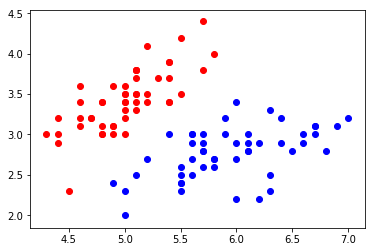

In [2]:
from utility import *

mydata = MyData(data_type='clf')
mydata.plot_data()

In [3]:
X, y = mydata.get_dataset()

# scikit-learnのロジスティック回帰

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=9, penalty='l2', solver='lbfgs', C=1)
lr.fit(X, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
lr.coef_

array([[ 3.0786959, -3.0220097]])

In [6]:
lr.intercept_

array([-7.30634549])

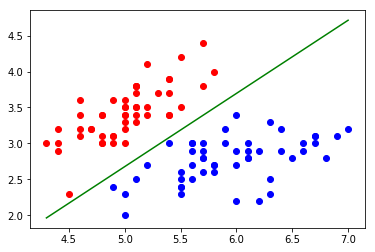

In [7]:
mydata.plot_boundary(lr.coef_[0], lr.intercept_)

# statsmodelのロジスティック回帰

In [8]:
import statsmodels.api as sm

s_lr = sm.Logit(y, sm.add_constant(X))
res = s_lr.fit(method='lbfgs')

In [9]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Sat, 09 May 2020   Pseudo R-squ.:                   1.000
Time:                        19:47:33   Log-Likelihood:             -0.0032555
converged:                       True   LL-Null:                       -69.315
                                        LLR p-value:                 7.914e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -289.3136   1.29e+07  -2.24e-05      1.000   -2.53e+07    2.53e+07
x1           156.0520   8.38e+06   1.86e-05      1.000   -1.64e+07    1.64e+07
x2          -182.2851   1.08e+07  -1.69e-05      1.0

## 係数の区間推定を行う

In [10]:
X_ = sm.add_constant(X)
y_pred = res.predict(sm.add_constant(X))

### フィッシャーの情報行列を求める

In [11]:
I = X_.T @ np.diag((y_pred) * (1-y_pred)) @ X_
I

array([[0.00324752, 0.0159469 , 0.00850612],
       [0.0159469 , 0.07895956, 0.04227671],
       [0.00850612, 0.04227671, 0.02267455]])

### 標準誤差

In [12]:
std_errors = np.sqrt(np.diag(np.linalg.inv(I)))
std_errors

array([12919871.82459653,  8373991.00038964, 10766559.85991333])

### z値とp値と信頼区間

In [13]:
z_values = res.params / std_errors
z_values

array([-2.23929193e-05,  1.86353201e-05, -1.69306700e-05])

In [15]:
from scipy.stats import norm

p_values = np.array([])
for z_value in z_values:
    if z_value >= 0:
        p_value = (1 - norm.cdf(z_value, loc=0, scale=1)) * 2
    else:
        p_value = norm.cdf(z_value, loc=0, scale=1) * 2
    p_values = np.hstack((p_values, p_value))
p_values

array([0.99998213, 0.99998513, 0.99998649])

In [16]:
# 信頼区間を求める
confidence_intervals = []
for s_i, w_i in zip(std_errors, res.params):
    left = s_i * norm.ppf(0.025, loc=0, scale=1) + w_i
    right = s_i * norm.ppf(0.975, loc=0, scale=1) + w_i
    confidence_intervals.append(np.array([left, right]))
confidence_intervals = np.array(confidence_intervals)
confidence_intervals

array([[-25322772.77472987,  25322194.14743612],
       [-16412564.71562383,  16412876.81962864],
       [-21102251.8478971 ,  21101887.27775237]])

結果がおおよそ一致している！

# 自力で実装

In [17]:
import numpy as np
from scipy.stats import norm
from IPython.core.display import display
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


class MyLogisticRegression():
    def __init__(self, fit_intercept=True, random_state=42, C=1.0):
        self.fit_intercept = fit_intercept
        self.random_state = random_state
        self.C = C
        return
    
    def __add_constant(self, X):
        return np.hstack((X, np.ones((len(X), 1))))
    
    def __calc_loss(self, y_true, y_pred):
        eps = 1e-15
        loss = -(-y_true * np.log(y_pred - eps) + (1 - y_true) * np.log(1 - y_pred + eps)).mean()
        return loss
    
    def __update_params(self, w, X, proba, y, lr):
        gradient = (X.T @ (proba - y))
        if self.C is None:
            w = w - lr / len(X) * gradient
        else:
            w = w - lr / len(X) * gradient - lr / self.C / len(X) * w
        return w
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_constant(X)
        
        # wの初期化
        np.random.seed(seed=self.random_state)
        self.w = np.random.rand(X.shape[1])
        
        # 設定
        lr = 1
        max_itr = 1000
        # 最急勾配法で更新
        for itr in range(max_itr):
            y_proba = self.predict_proba(X)
            log_loss = self.__calc_loss(y, y_proba)
            self.w = self.__update_params(self.w, X, y_proba, y, lr)
        self.coef_ = self.w[:-1]
        self.intercept_ = self.w[-1]
        
        # 区間推定を行う
        self.__calc_summary(X, y_proba)
        return
    
    def __calc_summary(self, X, y_proba):
        # フィッシャーの情報行列を求める
        I = X.T @ np.diag((y_proba) * (1-y_proba)) @ X
        
        # 標準誤差を求める
        std_errors = np.sqrt(np.diag(np.linalg.inv(I)))
        
        # z値を求める
        z_values = self.w / std_errors
        
        # p値を求める
        p_values = np.array([])
        for z_value in z_values:
            if z_value >= 0:
                p_value = (1 - norm.cdf(z_value, loc=0, scale=1)) * 2
            else:
                p_value = norm.cdf(z_value, loc=0, scale=1) * 2
            p_values = np.hstack((p_values, p_value))
        
        # 信頼区間を求める
        confidence_intervals = []
        for s_i, w_i in zip(std_errors, self.w):
            left = s_i * norm.ppf(0.025, loc=0, scale=1) + w_i
            right = s_i * norm.ppf(0.975, loc=0, scale=1) + w_i
            confidence_intervals.append(np.array([left, right]))
        confidence_intervals = np.array(confidence_intervals)
        
        # 説明変数の個数
        k = X.shape[1]
        
        if self.fit_intercept:
            names = [f'x_{i}' for i in range(1, k)]
            names.append('const')
        else:
            names = [f'x_{i}' for i in range(1, k+1)]
        
        summary_dict = {
            'name': names
            , 'coef': self.w
            , 'std err': std_errors
            , 'z': z_values
            , 'P>|z|': p_values
            , '[0.025': confidence_intervals[:, 0]
            , '0.975]': confidence_intervals[:, 1]
        }
        self.df_summary = pd.DataFrame.from_dict(summary_dict, orient='index').T
        return
        
    def summary(self):
        display(self.df_summary)
        return
        
    def predict_proba(self, X):
        if self.fit_intercept and X.shape[1] != len(self.w):
            X = self.__add_constant(X)
        return sigmoid(X @ self.w)
    
    def predict(self, X):
        y_proba = self.predict_proba(X)
        y_pred = (y_proba > 0.5).astype('int')
        return y_pred

    def score(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).sum() / len(y)

In [18]:
mlr = MyLogisticRegression(fit_intercept=True, C=None)
mlr.fit(X, y)
mlr.score(X, y)
mlr.summary()

,name,coef,std err,z,P>|z|,[0.025,0.975]
0,x_1,6.7662,2.1558,3.1385,0.0017,2.5408,10.9915
1,x_2,-10.9278,3.6158,-3.0222,0.0025,-18.0147,-3.8409
2,const,-2.8543,10.2902,-0.2774,0.7815,-23.0227,17.3141


In [19]:
mlr.w

array([  6.76615168, -10.92780862,  -2.8543029 ])

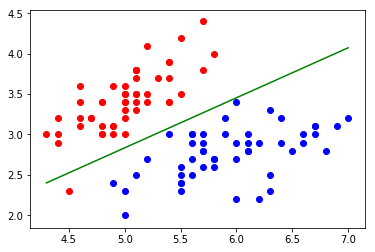

In [20]:
mydata.plot_boundary(mlr.w[:2], mlr.w[2])